## This notebook loads EPH data, cleans it and arranges it to be used as 'training sets'. 
That is, for fitting any Machine Learning model.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import numpy as np
pd.options.display.max_columns = 99

from IPython.display import display, HTML

import glob

In [2]:
startyr = 2003; endyr = 2022;

In [11]:
radio_ref = pd.read_csv('./../data/info/radio_ref.csv')

AGLO_Region = radio_ref[['AGLOMERADO', 'Region']].drop_duplicates()

# Decision sobre cual es la region de un aglomerado. GBA tiene que ir a Gran Buenos Aires, aunque algunos de sus radios en partidos como Rodriguez, Escobar, etc sean region pampeana.
# Viedma Patagones, se tendria que tirar de un lado, y la mayoria de sus radios, son Patagonia.
# Se tiene que corregir a mano, porque el AGLO 0 SI tiene varias regiones.

AGLO_Region = AGLO_Region.loc[~((AGLO_Region.AGLOMERADO == 33) & (AGLO_Region.Region == 'Pampeana'))]
AGLO_Region = AGLO_Region.loc[~((AGLO_Region.AGLOMERADO == 93) & (AGLO_Region.Region == 'Pampeana'))]

### Match column names

names_censo = ['IX_TOT', 'P02', 'P03', 'CONDACT', 'AGLOMERADO',
    'V01', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14', 'H13',
      'P07', 'P08', 'P09', 'P10', 'P05']


names_EPH = ['IX_TOT','CH04','CH06','CONDACT', 'AGLOMERADO',
    'IV1', 'IV3', 'IV4','IV5','IV6','IV7','IV8','IV10','IV11','II1','II2','II7','II8','II9',
    'CH09','CH10','CH12','CH13','CH15']

col_mon = [u'P21', u'P47T', u'PP08D1', u'TOT_P12', u'T_VI', u'V12_M', u'V2_M', u'V3_M', u'V5_M']



## Cargar IPC

### Trimestral

In [5]:
url = 'https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_Q.csv'

cpi = pd.read_csv(url, index_col = 0)
cpi.index = pd.to_datetime(cpi.index)
cpi = cpi['2003':]
cpi.tail()

## Forzar dia 15 del mes
cpi.index = cpi.index - pd.offsets.MonthBegin(1) + pd.offsets.Day(14)

### Mensual

In [6]:
url = 'https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_M.csv'

cpi_M = pd.read_csv(url, index_col = 0)[['index']]
cpi_M.index = pd.to_datetime(cpi_M.index)
cpi_M = cpi_M['2003':]
cpi_M.tail()

,index
2022-08-01,1145.545470
2022-09-01,1205.458397
2022-10-01,1268.504816
2022-11-01,1334.848613
2022-12-01,1404.662242


### Referencia de nivel de precios
### 2016 - 01 - 01

In [23]:
url = 'https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_d.csv'

cpi_d = pd.read_csv(url, index_col=0)[['index']]
cpi_d.index = pd.to_datetime(cpi_d.index)
cpi_d = cpi_d['2003':]

cpi_d.loc['2016-01-01']

index    100.0
Name: 2016-01-01 00:00:00, dtype: float64

In [ ]:
# ix = cpi_d.loc['2016-01-01'].values[0]

In [24]:
from datetime import datetime
mes_actual = datetime.today().replace(day=1).strftime("%Y-%m-%d")
cpi_M.loc[mes_actual]


index    1145.54547
Name: 2022-08-01 00:00:00, dtype: float64

## Cargar EPHs

Los microdatos de la Encuesta Permanente de Hogares se pueden descargar con:

``git clone https://github.com/matuteiglesias/microdatos-EPH-INDEC.git``

(darle star al repositorio)

tomando pull del mismo repositorio se va a poder actualizar con los nuevos microdatos a medida que se publican. 

``cd path/to/microdatos-EPH-INDEC``

``git pull``


Siempre y cuando el repositorio se mantenga actualizado. Y hasta que no se supere la capacidad de almacenamiento en repo github. 

El INDEC se toma aproximadamente 140 dias despues de terminado un trimestre (4 meses y medio) para subir las bases de microdatos. 

In [25]:
## When running the first time we may not have the folder where training data is saved
import os

if not os.path.exists('./../data/training/'):
    os.makedirs('./../data/training/')

In [26]:
overwrite = True

In [77]:
# from pandas.tseries.offsets import MonthEnd

path ='./../../microdatos-EPH-INDEC/microdatos/' # depende de donde hayamos descargado los microdatos
# path ='./../../EPH/microdatos/' # depende de donde hayamos descargado los microdatos

for y in range(startyr, endyr):
    print(y)
    yr = str(y)[2:]
    training_file = './../data/training/EPHARG_train_'+str(yr)+'.csv'
    
    # Si todavia no existe la training data de ese anio, o si la opcion overwrite esta activada:
    if (not os.path.exists(training_file)) or (overwrite): 

        allFiles = glob.glob(path + 'hogar/*'+str(yr)+'.txt')
        frame = pd.DataFrame()
        list_ = []
        for file_ in allFiles:
            df = pd.read_csv(file_,index_col=None, header=0, delimiter = ';',
                            usecols = ['CODUSU','ANO4','TRIMESTRE','IX_TOT', 'AGLOMERADO',
            'IV1', 'IV3', 'IV4','IV5','IV6','IV7','IV8','IV10','IV11','II1','II2','II7','II8','II9']) 

            print(len(df))
            list_ += [df]
        df = pd.concat(list_)

        # Correcciones Respuestas. Para que matchee censo
        df = df.loc[df.IV1 != 9]
        df['IV10'] = df['IV10'].map({1: 1, 2: 2, 3: 2, 0: 0, 9: 9})
        df['II9'] = df['II9'].map({1: 1, 2: 2, 3: 2, 4: 4, 0: 0})
        df['II7'] = df['II7'].map({1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 6, 8: 6, 9: 6, 0: 0})
        df['IX_TOT'] = df['IX_TOT'].clip(0, 8)

        hogar = df
        hogar = hogar.drop_duplicates()
        print(hogar.shape)

        allFiles = glob.glob(path + 'individual/usu_individual*'+str(yr)+'.txt')
        frame = pd.DataFrame()
        list_ = []
        for file_ in allFiles:
            print(file_)
        #     print(file_)
            df = pd.read_csv(file_,index_col=None, header=0, delimiter = ';',
                             usecols = ['CODUSU','ANO4','TRIMESTRE','CH04','CH06', 'AGLOMERADO', 'CH09','CH10','CH12','CH13','CH15'] +\
                             ['CH07', 'ESTADO','CAT_INAC','CAT_OCUP','PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K',
                             'P47T', 'V3_M', 'T_VI', 'V12_M', 'TOT_P12', 'V5_M','V2_M', 'PP08D1', 'P21'])
            df = df.rename(columns = {'ESTADO': 'CONDACT'})


            list_ += [df]
        df = pd.concat(list_)

        # Correcciones Respuestas. Para que matchee censo
        df['CH15'] = df['CH15'].map({1:1, 2:1, 3:1, 4:2, 5:2, 9:0})
        df['CH06'] = df['CH06'].clip(0)
        df['CH09'] = df['CH09'].map({1:1, 2:2, 0:2, 3:2})
        df.loc[df['CH06'] < 14, 'CONDACT'] = 0 # Menores de 14 van con CONDACT 0, como en el Censo

        ## En Censo, Jardin y educacion especial no preguntan terminado si/no.
        df['CH12'] = df.CH12.replace(99, 0)
        df.loc[df.CH12.isin([0, 1, 9]), 'CH13'] = 0

    #     df['MAYOR'] = df['CH06'] >= 14 
    #     df['MAYOR'] = df['CH06'] // 7
    #     df['CONDACT'] = df['CAT_OCUP'].fillna(-1)

        indiv = df
        indiv = indiv.dropna(subset = ['P47T'])
        print(indiv.shape)

        indiv_table = indiv[list(indiv.columns.difference(hogar.columns)) + ['CODUSU', 'ANO4', 'TRIMESTRE', 'AGLOMERADO']]
        EPH = hogar.merge(indiv_table, on = ['CODUSU', 'ANO4', 'TRIMESTRE', 'AGLOMERADO'])#, indicator = True)

        print('Hogar - Indiv merged:')
        print(EPH.shape)


    #     EPH = EPH.loc[EPH.P47T != -9]

        EPH = EPH.merge(AGLO_Region)

        EPH_no_aglo = EPH.copy(); 
        EPH_no_aglo['AGLOMERADO'] = 0

        EPH = pd.concat([EPH, EPH_no_aglo]).reset_index(drop = True)

        print('No aglo agregado:')
        print(EPH.shape)

    #     # Quarters / deflation
    #     EPH['Q'] = EPH.ANO4.astype(str) + ':' + (3*EPH.TRIMESTRE).astype(str)
    #     EPH['Q'] = pd.to_datetime(EPH['Q'], format='%Y:%m') + MonthEnd(1)
    # #     cpi_ultimo_Q = indice_precios['index'].values[-1]

        # Quarters / deflation
        EPH['Q'] = EPH.ANO4.astype(str) + ':' + (3*EPH.TRIMESTRE).astype(str)
        EPH['Q'] = pd.to_datetime(EPH['Q'], format='%Y:%m') - pd.DateOffset(months=1) + pd.DateOffset(days=14)
        print(EPH['Q'].unique())


    #     EPH[col_mon] = cpi_mes_actual*EPH[col_mon].div(EPH[['Q'] + col_mon].merge(cpi, on = 'Q', how = 'left')['index'].values, 0)
        EPH[col_mon] = ix*EPH[col_mon].div(EPH[['Q'] + col_mon].merge(cpi, on = 'Q', how = 'left')['index'].values, 0)

        # 2018Q3 -> Mar19 1.3156
        # 2018Q3 -> Abr19 1.361
    #     EPH[col_mon] = 1.361*EPH[col_mon]

        EPH[col_mon] = EPH[col_mon].round()

        print('deflactado:')
        print(EPH.shape)
#         display(EPH[col_mon].mean())

        training = EPH.rename(columns = dict(zip(names_EPH, names_censo)))
        
        # remove bad observations
        training = training.loc[training.P47T >= -0.001].fillna(0)
        
        for col in ['CAT_OCUP', 'CH07', 'PP07G1', 'PP07G_59', 'PP07I', 'PP07J', 'PP07K']:
            training = training.loc[training[col] != 9]

        ### RANKING AGLOMERADO
        AGLO_rk = training.loc[(training.CAT_OCUP == 3) & (training.P47T >= 100)].groupby(['ANO4', 'AGLOMERADO'])[['P47T']].mean()
        AGLO_rk['AGLO_rk'] = AGLO_rk.rank(pct = True).round(3)
        AGLO_rk = AGLO_rk.sort_values('P47T').reset_index()

        ### RANKING REGION
        Reg_rk = training.loc[(training.CAT_OCUP == 3) & (training.P47T >= 100)].groupby(['ANO4', 'Region'])[['P47T']].mean()
        Reg_rk['Reg_rk'] = Reg_rk.rank(pct = True).round(3)
        Reg_rk = Reg_rk.sort_values('P47T').reset_index()
            
        training = training.merge(AGLO_rk[['ANO4', 'AGLOMERADO', 'AGLO_rk']]).merge(Reg_rk[['ANO4', 'Region', 'Reg_rk']])
        
        ## Crear columnas binarias para ingreso.
        training['INGRESO'] = (training.P47T > 100).astype(int)
        training['INGRESO_NLB'] = (training.T_VI > 100).astype(int)
        training['INGRESO_JUB'] = (training.V2_M > 100).astype(int)
        training['INGRESO_SBS'] = (training.V5_M > 100).astype(int)
        
        ## Ordenar por id de hogar.
        training = training.sort_values('CODUSU')
        
        training.to_csv(training_file, index = False)

2003
13180
13325
(26483, 19)
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t403.txt
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t303.txt
(93244, 33)
Hogar - Indiv merged:
(96827, 48)
No aglo agregado:
(193654, 49)
['2003-08-15T00:00:00.000000000' '2003-11-15T00:00:00.000000000']
deflactado:
(193654, 50)
2004
13497
13809
12816
13806
(53873, 19)
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t404.txt
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t104.txt
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t204.txt
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t304.txt
(187930, 33)
Hogar - Indiv merged:
(193742, 48)
No aglo agregado:
(387484, 49)
['2004-11-15T00:00:00.000000000' '2004-05-15T00:00:00.000000000'
 '2004-02-15T00:00:00.000000000' '2004-08-15T00:00:00.000000000']
deflactado:
(387484, 50)
2005
13807
13511
13704
13597
(54562, 19)
./../../microdatos-EPH-INDEC/microda

./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t418.txt
(229794, 33)
Hogar - Indiv merged:
(234346, 48)
No aglo agregado:
(468692, 49)
['2018-11-15T00:00:00.000000000' '2018-02-15T00:00:00.000000000'
 '2018-08-15T00:00:00.000000000' '2018-05-15T00:00:00.000000000']
deflactado:
(468692, 50)
2019
19035
18610
19251
19338
(76165, 19)
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t119.txt
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t419.txt
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t319.txt
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t219.txt
(234083, 33)
Hogar - Indiv merged:
(238760, 48)
No aglo agregado:
(477520, 49)
['2019-11-15T00:00:00.000000000' '2019-08-15T00:00:00.000000000'
 '2019-05-15T00:00:00.000000000' '2019-02-15T00:00:00.000000000']
deflactado:
(477520, 50)
2020
16845
11976
14442
13503
(56724, 19)
./../../microdatos-EPH-INDEC/microdatos/individual/usu_individual_t220.tx

### Ranking de AGLOS y Regiones

A continuacion se extrae el ranking de aglomerados y regiones para cada uno de los anios.

In [78]:
aglo_list = []
regs_list = []

startyr = 2003; endyr = 2022;
for y in range(startyr, endyr):
    print(y)
    yr = str(y)[2:]
    training_file = './../data/training/EPHARG_train_'+str(yr)+'.csv'
    
    aglo_table = pd.read_csv(training_file, usecols = ['ANO4', 'AGLOMERADO', 'AGLO_rk']).drop_duplicates()
    aglo_list += [aglo_table]
    
    regs_table = pd.read_csv(training_file, usecols = ['ANO4', 'Region', 'Reg_rk']).drop_duplicates()
    regs_list += [regs_table]
    
aglo_rk = pd.concat(aglo_list)
regs_rk = pd.concat(regs_list)

aglo_rk.to_csv('./../data/info/AGLO_rk', index = False)
regs_rk.to_csv('./../data/info/Reg_rk', index = False)

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

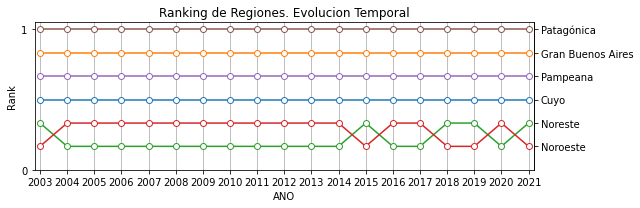

In [10]:
df = pd.read_csv('./../data/info/Reg_rk')

## Nombres de aglo en el ultimo anio para label Y
ref = df.loc[df.ANO4 == df.ANO4.max()].sort_values('Reg_rk', ascending = False)

fig, ax = plt.subplots(figsize = (9, 3), subplot_kw = dict(ylim = (1.05, 0), xlim = (startyr - .2, endyr - .8)))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
yax2 = ax.secondary_yaxis("right")
yax2.yaxis.set_major_locator(FixedLocator(ref["Reg_rk"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(ref["Region"].to_list()))

ax.set(xlabel="ANO", ylabel="Rank", title="Ranking de Regiones. Evolucion Temporal")
for i, j in df.groupby("Region"):
    plt.plot("ANO4", "Reg_rk", "o-", data=j, mfc="w")
    
ax.set_xticks(range(startyr, endyr))
ax.invert_yaxis()
ax.grid(axis="x")
plt.savefig('./../figuras/reg_rk.jpg')
plt.tight_layout()

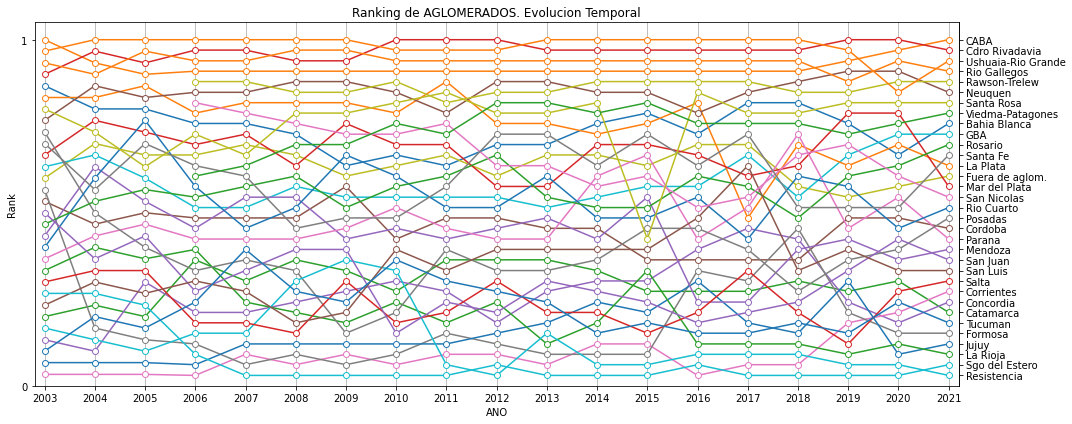

In [11]:
aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')
df = pd.read_csv('./../data/info/AGLO_rk')
df = df.merge(aglo_labels)
## Nombres de aglo en el ultimo anio para label Y
ref = df.loc[df.ANO4 == df.ANO4.max()].sort_values('AGLO_rk', ascending = False)

fig, ax = plt.subplots(figsize = (15, 6), subplot_kw = dict(ylim = (1.05, 0), xlim = (startyr - .2, endyr - .8)))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
yax2 = ax.secondary_yaxis("right")
yax2.yaxis.set_major_locator(FixedLocator(ref["AGLO_rk"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(ref["NOMAGLO"].to_list()))

ax.set(xlabel="ANO", ylabel="Rank", title="Ranking de AGLOMERADOS. Evolucion Temporal")
for i, j in df.groupby("NOMAGLO"):
    ax.plot("ANO4", "AGLO_rk", "o-", data=j, mfc="w")
    
ax.set_xticks(range(startyr, endyr))
ax.invert_yaxis()
ax.grid(axis="x")
plt.savefig('./../figuras/aglo_rk.jpg')
plt.tight_layout()

In [ ]:
# df_list = []

# for yr in [str(s) for s in range(2017, 2022)]:
#     print(yr)
#     train = pd.read_csv('./../data/training/EPHARG_train_'+yr[2:]+'.csv')
#     train = train.loc[train.P47T >= -0.001].fillna(0)#.sample(400000)
#     df_list += [train]
    
# train_df = pd.concat(df_list)

# AGLO_rk = train_df.loc[train_df.CAT_OCUP == 3].groupby(['AGLOMERADO'])[['P47T']].mean().sort_values('P47T').reset_index().reset_index().rename(columns = {'index':'AGLO_rk'})
# Reg_rk = train_df.loc[train_df.CAT_OCUP == 3].groupby(['Region'])[['P47T']].mean().sort_values('P47T').reset_index().reset_index().rename(columns = {'index':'Reg_rk'})

# AGLO_rk['AGLO_rk'] = AGLO_rk.AGLO_rk/AGLO_rk.AGLO_rk.max()
# AGLO_rk.to_csv('./../data/info/AGLO_rk', index = False)
# Reg_rk['Reg_rk'] = Reg_rk.Reg_rk/Reg_rk.Reg_rk.max()
# Reg_rk.to_csv('./../data/info/Reg_rk', index = False)

# # check it out
# # AGLO_rk.merge(pd.read_csv('./../data/info/aglo_labels.csv'))

## Guardar training dataset

In [ ]:
# AGLO_rk = pd.read_csv('./../data/info/AGLO_rk')
# Reg_rk = pd.read_csv('./../data/info/Reg_rk')

# df_list = []
# for yr in [str(s) for s in range(startyr, endyr)]:
# # for yr in [str(s) for s in range(startyr, endyr)]:
#     print(yr)
#     train = pd.read_csv('./../data/training/EPHARG_train_'+yr[2:]+'.csv')#.drop(['AGLO_rk', 'Reg_rk'], axis = 1)
#     train = train.loc[train.P47T >= -0.001].fillna(0)
#     train = train.merge(AGLO_rk[['AGLOMERADO', 'AGLO_rk']]).merge(Reg_rk[['Region', 'Reg_rk']])
#     train.to_csv('./../data/training/EPHARG_train_'+yr[2:]+'.csv', index = False)

## Listo. Salvado el training set.